<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Computing correlations in `Pyleoclim`

## Authors

Julien Emile-Geay, USC Earth Sciences

Feng Zhu, NUIST

Author1 = {"name": "Julien Emile-Geay", "affiliation": "Department of Earth Sciences, University of Southern California", "email": "julieneg@usc.edu", "orcid": "0000-0001-5920-4751"}

Author2 = {"name": "Feng Zhu", "affiliation": "Nanjing University of Information Science and Technology", "email": "fzhu@nuist.edu", "orcid": "0000-0002-9969-2953"}


## Preamble
### Introduction 

Correlation analysis, despite its simplicity and many shortcomings, remains a centerpiece of empirical analysis in many fields, particularly the paleosciences. Computing correlations is trivial enough; the difficulty lies in properly assessing their significance. Of particular importance are three considerations:
- **Persistence**, which violates the standard assumption that the data are independent (which underlies the classical test of significance implemented, e.g. in Excel). 
- **Time irregularities**, for instance comparing two records with different time axes, possibly unevenly spaced (which standard software cannot deal with out of the box)
- **Age uncertainties** for example comparing two records, each with an ensemble of plausible chronologies (generated, for instance, by a Bayesian age model)
- **Test multiplicity** aka the "Look Elsewhere effect", which states that repeatedly performing the same test can result in unacceptably high type I error (accepting correlations as significant, when in fact they are not). This arises e.g. when correlating a paleoclimate record with an instrumental field, assessing significance at thounsands of grid points at once, or assessing significance within an age ensemble.

Accordingly,  `Pyleoclim` facilitates an assessment of correlations that deals with all these cases, makes the necessary data transformations transparent to the user, and allows for one-line plot commands to visualize the results. 


### Goals 
In this notebook, we illustrate some of these capabilities with several simple scenarios, including:
1. Correlating a single `Series` object with another, both with consistent time axis
2. Correlating a single `Series` object with another, with inconsistent time axis 
3. Correlating a `MultipleSeries` object with a `Series` object as target
4. Correlating a `MultipleSeries` object without a given target 
5. Correlating a `EnsembleSeries` object with a `Series` object as target
6. Correlating a `EnsembleSeries` object with a given target
7. Correlating two `EnsembleSeries` objects

For a primer on these data structures, see the [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html).

**Reading Time: 20 min**

### Keywords
Correlations, Surrogates, Significance, Visualization 

### Pre-requisites
some basics statistics

### Relevant Packages
pyleoclim, matplotlib, xarray, cartopy


## Data Description
- Coral Sr/Ca series (a proxy for sea-surface temperature) by [Nurhati et al (2011)](https://doi.org/10.1175/2011JCLI3852.1). The data are from Palmyra Island in the tropical Pacific, at the edge of the NINO3.4 box (a popular measure of the state of El Niño Southern Oscillation). 
- Sea-surface temperature analysis of ERSSTv5 [(Huang et al, 2017)](https://10.1175/JCLI-D-16-0836.1)


In [6]:
import pyleoclim as pyleo
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

First let's load the coral data:

In [2]:
d = pyleo.Lipd('../data/Ocn-Palmyra.Nurhati.2011.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Ocn-Palmyra.Nurhati.2011.lpd
Finished read: 1 record


extracting paleoData...
extracting: Ocn-Palmyra.Nurhati.2011
Created time series: 5 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Year [AD]', ylabel='Sr_Ca [mmol/mol]'>)

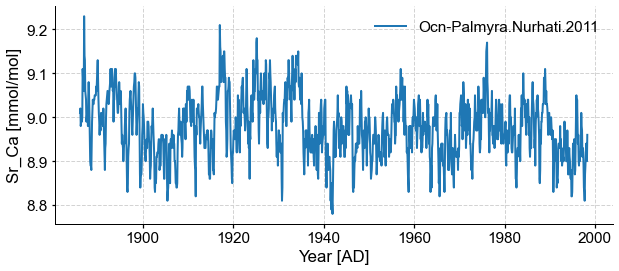

In [4]:
srca = d.to_LipdSeries(number=2) # load only the Sr/Ca observations
srca.plot()

Next we load the ERSSTv5 data. Note that the actual dat are not being transferred over the network yet ; all we are getting is a pointer towards those data. The real crunching will come later.

In [8]:
filepath = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ersstv5 = xr.open_dataset(filepath)
ersstv5

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2023)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-08-07
    DODS_EXTRA.Unlimited_Dimension:  time

Let's select a smaller portion of this dataset to correlate with the Sr/Ca record:

In [18]:
ersstv5_tp = ersstv5.sel(lat=slice(40, -10), lon=slice(110, 290))
ersstv5_tp

<xarray.Dataset>
Dimensions:    (lat: 26, lon: 91, nbnds: 2, time: 2023)
Coordinates:
  * lat        (lat) float32 40.0 38.0 36.0 34.0 32.0 ... -4.0 -6.0 -8.0 -10.0
  * lon        (lon) float32 110.0 112.0 114.0 116.0 ... 284.0 286.0 288.0 290.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-08-07
    DODS_EXTRA.Unlimited_Dimension:  time

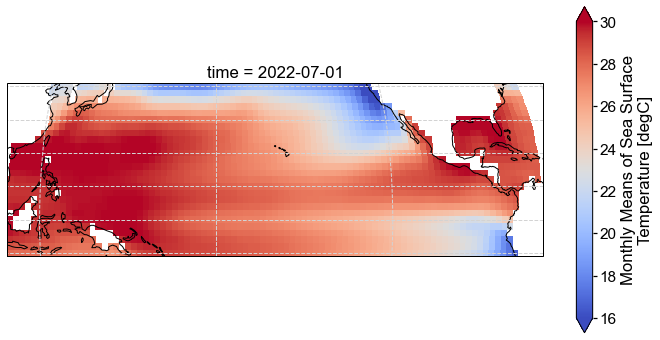

In [19]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ersstv5_tp.sst.isel(time=-1).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=16, vmax=30, cmap='coolwarm'
);

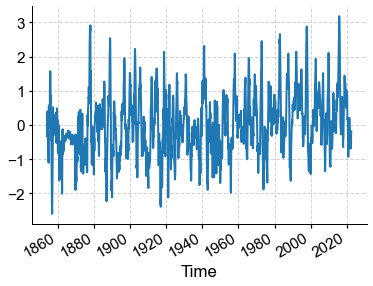

In [28]:
nino34_box = ersstv5_tp.sel(lat=slice(5, -5), lon=slice(190, 240))
gb = nino34_box.sst.groupby('time.month')
nino34_anom = gb - gb.mean(dim='time')
weights = np.cos(np.deg2rad(nino34_box.lat))
nino34 = nino34_anom.weighted(weights).mean(dim=['lat', 'lon'])
nino34.plot()

In [33]:
nino34['time'].values

array(['1854-01-01T00:00:00.000000000', '1854-02-01T00:00:00.000000000',
       '1854-03-01T00:00:00.000000000', ...,
       '2022-05-01T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

The date format is datetime64, which for the moment is not understood by Pyleoclim (it will be the case in a few releases, after pandas 1.5 is released and integrated into `pyleoclim`). We thus need to transform it to decimal years with the help of this [nifty function from PyAstronomy](https://github.com/sczesla/PyAstronomy/blob/master/src/pyasl/asl/decimalYear.py). 

In [40]:
def ymd2year_float(year, month, day):
    ''' Convert a set of (year, month, day) to an array of floats in unit of year
    '''
    year_float = []
    for y, m, d in zip(year, month, day):
        date = datetime(year=y, month=m, day=d)
        fst_day = datetime(year=y, month=1, day=1)
        lst_day = datetime(year=y+1, month=1, day=1)
        year_part = date - fst_day
        year_length = lst_day - fst_day
        year_float.append(y + year_part/year_length)

    year_float = np.asarray(year_float)
    return year_float

def datetime2year_float(date):
    ''' Convert a list of dates to floats in year
    '''
    if isinstance(date[0], np.datetime64):
        date = pd.to_datetime(date)

    year = [d.year for d in date]
    month = [d.month for d in date]
    day = [d.day for d in date]

    year_float = ymd2year_float(year, month, day)

    return year_float

In [49]:
n34_time = nino34['time'].to_pandas()


AttributeError: 'Series' object has no attribute 'year'

In [42]:
nino34ts = pyleo.Series(time = nino34['time'].values, value = datetime2year_float(nino34.values),value_name='NINO3.4',
                        value_unit= '$^\circ$C', label='Niño3.4 SST')
nino34ts.plot()

AttributeError: 'numpy.float32' object has no attribute 'year'

Now we can compute correlations between the Nurhati et al (2011) Sr/Ca dataset and NINO3.4:

In [ ]:
corr1 = .correlation(ts_nino_evenly)
print(corr1)

## Test data

We load the `ninoairdata` from Matlab (see https://www.mathworks.com/help/wavelet/ref/wcoherence.html) as our test data, which contains a series of air temperature and the [NINO3 SST index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni).

In [3]:
# load data
data = sio.loadmat('../example_data/wtc_test_data_nino.mat')
air = data['air'][:, 0]
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]
print('data length:', np.size(t))

data length: 1596


We randomly delete 500 data points from the original test data to create an inconsistent time axis for later test of the package's functionality.

In [4]:
# randomly delete 500 data points
n_del = 500
np.random.seed(2333)
deleted_idx_air = np.random.choice(range(np.size(t)), n_del, replace=False)
np.random.seed(2334)
deleted_idx_nino = np.random.choice(range(np.size(t)), n_del, replace=False)
air_value_unevenly =  np.delete(air, deleted_idx_air)
air_time_unevenly =  np.delete(t, deleted_idx_air)
nino_value_unevenly =  np.delete(nino, deleted_idx_nino)
nino_time_unevenly =  np.delete(t, deleted_idx_nino)
print('Time axis of air:', air_time_unevenly)
print('Time axis of nino:', nino_time_unevenly)

# define Series
ts_air_evenly = pyleo.Series(time=t, value=air)
ts_nino_evenly = pyleo.Series(time=t, value=nino)
ts_air_unevenly = pyleo.Series(time=air_time_unevenly, value=air_value_unevenly)
ts_nino_unevenly = pyleo.Series(time=nino_time_unevenly, value=nino_value_unevenly)

Time axis of air: [1871.08 1871.17 1871.25 ... 2003.42 2003.58 2003.75]
Time axis of nino: [1871.08 1871.25 1871.33 ... 2003.42 2003.5  2003.58]


## Case 1: 1 `Series` vs 1 `Series`, with consistent time axis
This is the simplest case, though it already illustrates problem #1 (the loss of independence of consecutive values due to autocorrelation, a form of persistence). To deal with this, `correlation` calls the function `corr_sig` (see [documentation](https://pyleoclim-util.readthedocs.io/en/stable/utils/correlation/corr_sig.html?highlight=corr_sig)), which uses an isospectral test of significance (generating 1000 surrogates of the original series by phase randomization, computing pairwise correlations, and gauging the original correlation against this ensemble). This approach is non-parametric, making no assumption about the structure of the series, and it is computationally quite fast except for very long series (over 10,000 points or so, on a typical laptop).  As you'll see now, for two short series, this computation is nearly instantaneous:

In [4]:
corr_res = ts_air_evenly.correlation(ts_nino_evenly)
print(corr_res)

{'r': -0.15239413332839044, 'signif': True, 'p': 0.0}


The output of `correlation` is a simple dictionary containing 3 pieces of information: the numerical value of the correlation, a boolean flag saying whether it is significan or not, and an estimate of the p-value. In this case, a value of 0 means that the observed correlation of -0.152 is larger (in absolute value) than those of all the surrogate pairs, and is therefore significant by this test.

## Case 2: 1 `Series` vs 1 `Series`, with inconsistent time axis

Now we compute the same correlation, but with the two series containing gaps in the time axis (our second challenge). Under the hood, what happens in this case is that the two `Series` objects are grouped as a `MultipleSeries` and the function `MultipleSeries.common_time()` is called to align the time axes utilizing either binning (default) or interpolation. 

In [5]:
corr_res = ts_air_unevenly.correlation(ts_nino_unevenly)
print(corr_res)

{'r': -0.18121262364176918, 'signif': True, 'p': 0.0}


Notice here that the correlation has increased (in absolute value) as a result of the time gaps. This shows how  age errors do not always decrease correlations (a commonly held assumption). As before, it only took two lines of code to get this result, but a lot has happened under the hood.

## Case 3: 1 `MultipleSeries` vs 1 `Series`

Now imagine that you have a stack of records stored in a `MultipleSeries` object, which you want to correlate to a target (say, a climate index). 

For simplicity, we construct our `MultipleSeries` object by adding Gaussian white noise to the air temperature data. In this case, each member of the `MultipleSeries` will be compared to the target `Series`, and the result contains a list of correlation coefficients, a list of p-values, and a list of significance boolean values.

In [11]:
nt = np.size(ts_air_unevenly.time)
n_ens = 10  # ensemble size
ts_list = []
for i in range(n_ens):
    np.random.seed(i)
    noise = np.random.normal(loc=0, scale=2, size=nt)
    value = air_value_unevenly + noise
    new_ts = pyleo.Series(time=air_time_unevenly, value=value)
    ts_list.append(new_ts)
    
ms_air = pyleo.MultipleSeries(ts_list)
corr_res = ms_air.correlation(ts_nino_unevenly)

## Case 4: 1 `MultipleSeries` without a given target

If no target is provided (that is, if `correlation()` is applied to the `MultipleSeries` object by itself, the object's first member will be used as the target.

In [7]:
nt = np.size(ts_air_unevenly.time)
n_ens = 10  # ensemble size
ts_list = []
for i in range(n_ens):
    np.random.seed(i)
    noise = np.random.normal(loc=0, scale=2, size=nt)
    value = air_value_unevenly + noise
    new_ts = pyleo.Series(time=air_time_unevenly, value=value)
    ts_list.append(new_ts)
    
ms_air = pyleo.MultipleSeries(ts_list)
corr_res = ms_air.correlation()
# note here the target Series is not specified, and the 1st Series inside
# the MultipleSeries itself will be used as the target
print(corr_res)

{'r': [0.9999999999999998, 0.9999374125312044, 0.99993714372365, 0.9999344305144189, 0.9999415547035191, 0.9999395155655999, 0.9999375301231063, 0.9999391257891026, 0.9999343293322345, 0.9999376433287493], 'p': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'signif': [True, True, True, True, True, True, True, True, True, True]}


## Case 5: 1 `EnsembleSeries` vs 1 `Series`

This case is very similar to Case 3, except that we create an `EnsembleSeries` object to emphasize that the 100 members are from an ensemble. To speed up computations, we use the adjusted T-test option here, but recommend sticking with the default (isosopectral) test in a real scientific setting.

In [12]:
nt = np.size(ts_air_unevenly.time)
n_ens = 100  # ensemble size
ts_list = []
for i in range(n_ens):
    np.random.seed(i)
    noise = np.random.normal(loc=0, scale=500, size=nt)
    value = air_value_unevenly + noise
    new_ts = pyleo.Series(time=air_time_unevenly, value=value)
    ts_list.append(new_ts)
    
ms_air = pyleo.EnsembleSeries(ts_list)
corr_res = ms_air.correlation(ts_nino_unevenly, settings={'method': 'ttest'})  # use 'ttest' only to accelerate
print(corr_res)

/Users/julieneg/opt/miniconda3/envs/pyleo/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATI

  correlation      p-value  signif. w/o FDR (α: 0.05)    signif. w/ FDR (α: 0.05)
-------------  -----------  ---------------------------  --------------------------
   -0.0722541  0.0931532    False                        False
   -0.137045   0.00178246   True                         True
   -0.0827459  0.0586829    False                        False
   -0.0858156  0.037572     True                         False
   -0.115069   0.00894096   True                         True
   -0.0618856  0.148731     False                        False
   -0.0252093  0.573724     False                        False
   -0.0807701  0.0739858    False                        False
   -0.134809   0.00153498   True                         True
   -0.110243   0.0130214    True                         True
   -0.114631   0.0114226    True                         True
   -0.0555839  0.209962     False                        False
   -0.0258361  0.543172     False                        False
   -0.104202   0.017

Now this gets unwieldy to interpret. To ease this step, `Pyleoclim` provides the option to visualize the result in a simple line call:

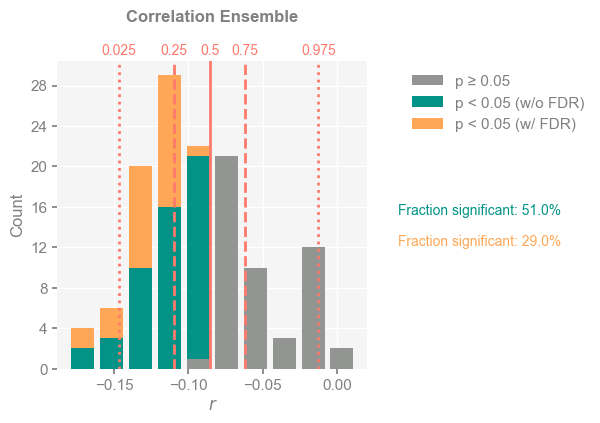

In [119]:
pyleo.set_style('web')
fig, ax = corr_res.plot(title='Correlation Ensemble')

On this plot, gray bars represent the histogram of observed correlations, green bars mark those correlations significant at the 5% level, which comprise about half of the ensemble. Now, as we alluded to earlier, this may be an artifact of multiple testing, which will lead us to accept many results as "significant" if we conduct the same test repeatedly. To mitigate this,  `Pyleoclim` implements the False Discovery Rate procedure of [Benjamini & Hochberg (1995)](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x).  (more on this below). This is shown in the orange bars, which together cover about 29% of the cases (i.e. 2/3 of the correlations identified as significant without the FDR procedure). We note that it is the green + orange bars together that correspond to the 51% of the cases identified thus. 

## Case 6: 1 `EnsembleSeries` without a given target

This case is similar to Case 4, but for ensembles, and the function works similarly. 

In [ ]:
nt = np.size(ts_air_unevenly.time)
n_ens = 10  # ensemble size
ts_list = []
for i in range(n_ens):
    np.random.seed(i)
    noise = np.random.normal(loc=0, scale=2, size=nt)
    value = air_value_unevenly + noise
    new_ts = pyleo.Series(time=air_time_unevenly, value=value)
    ts_list.append(new_ts)
    
ms_air = pyleo.EnsembleSeries(ts_list)
corr_res = ms_air.correlation()  # note here the target Series is not specified
print(corr_res)

Again, with a large ensemble one could visualize the histogram of correlations as above.

## Case 7: 1 `EnsembleSeries` vs 1 `EnsembleSeries`

The sizes of the two `EnsembleSeries` objects can be different.
Suppose we name the two groups as A and B, then
the calculation of correlations will follow a pairwise procedure,
i.e., compare the 1st (2nd, 3rd, ...) member from A to the 1st (2nd, 3rd, ..) member from B, and stop when running out of members from either group.

For simplicity, we construct two `EnsembleSeries` by adding normal distribution noise realizations to the air temperature data and the NINO index data, respectively.

In [10]:
nt = np.size(ts_air_unevenly.time)
n_ens = 10  # ensemble size
ts_list = []
for i in range(n_ens):
    np.random.seed(i)
    noise = np.random.normal(loc=0, scale=2, size=nt)
    value = air_value_unevenly + noise
    new_ts = pyleo.Series(time=air_time_unevenly, value=value)
    ts_list.append(new_ts)
    
ms_air = pyleo.EnsembleSeries(ts_list)
    
ts_list = []
for i in range(n_ens):
    np.random.seed(i+1000)
    noise = np.random.normal(loc=0, scale=2, size=nt)
    value = nino_value_unevenly + noise
    new_ts = pyleo.Series(time=nino_time_unevenly, value=value)
    ts_list.append(new_ts)
    
ms_nino = pyleo.EnsembleSeries(ts_list)
corr_res = ms_air.correlation(ms_nino)
print(corr_res)

{'r': [-0.06195751074732453, -0.10209380192583367, -0.09066183585437274, -0.15743916878394076, -0.1000232197636787, -0.12656628638817705, -0.09416557016689492, -0.10103790337916829, -0.03112547988169663, -0.10116481169893426], 'p': [0.095, 0.0, 0.009, 0.0, 0.003, 0.0, 0.007, 0.005, 0.381, 0.006], 'signif': [False, True, True, True, True, True, True, True, False, True]}


To properly illustrate correlations with age-uncertain ensembles based on real datasets, see examples in [LiPDBooks](https://github.com/LinkedEarth/LiPDbooks/tree/master/notebooks).

## About `apply_fdr` in `EnsembleSeries.correlation()`

One major difference between `MultipleSeries.correlation()` and `EnsembleSeries.correlation()` is that the latter has the argument `apply_fdr=True` by default, which means that in an ensemble context, the FDR approach is  to applied by default to determine whether the calculated p-values are significant. You can opt out of it by setting the flag to `False`, but not before carefully considering whether this is wise. 

Below we  explain the basic idea of FDR and demonstrate the use of `Pyleoclim`'s underlying FDR function with two simple tests to help understand the idea.

### Basic idea of FDR
Quoting from [Ventura et al. (2004)](https://journals.ametsoc.org/doi/full/10.1175/3199.1): "A single test performed at signiﬁcance level $\alpha$ has probability $\alpha$ of rejecting the null hypothesis when it is in fact true. Hence if $n$ such tests are performed when all $n$ null hypotheses are true (the collective null hypothesis), then the average number of tests for which the null is falsely rejected is $n\alpha$. For example, with $\alpha = 5\%$, testing for a trend at 1000 locations at which no change really occurred would yield 50 signiﬁcant locations on average; this is unacceptably high."

To overcome this disadvantage, there have been some alternatives, among which the enormously popular False Discovery Rate (FDR), introduced by Benjamini & Hochberg (1995) (BH95 hereafter). There are other variants such as Yekutieli & Benjamini (1999, 2001), and Ventura et al. (2004).

The idea is as follows: a multiple testing procedure, returns a list of $p$-values.
With the traditional false positive test, the significance level $\alpha=0.05$ is refered as the false positive rate (FPR), and we reject null hypothesis $H_0$ at all locations $p_i < \alpha$.

In the original BH95 method, the nominal FDR, denoted by $q$, is defined as the rate we are willing to allow of false rejections out of all rejections, and is usually set to $5\%$. The BH95 procedure rejects $H_0$ in all cases $i$ for which $p_i \le p_k$, where $k = \max_{i=0,...,n} \{i: p_{(i)}\le q i/n \}$. For an illustration, see Fig 2 of [Hu et al (2017)](http://dx.doi.org/10.1016/j.epsl.2016.11.048).

### The underlying FDR function in `Pyleoclim`

In [11]:
from pyleoclim.utils.correlation import fdr

?fdr

Signature: fdr(pvals, qlevel=0.05, method='original', adj_method=None, adj_args={})
Docstring:
Determine significance based on the FDR approach

The false discovery rate is a method of conceptualizing the rate of type I errors in null hypothesis testing when conducting multiple comparisons. 
Translated from fdr.R by Dr. Chris Paciorek 

Parameters
----------

pvals : list or array
    A vector of p-values on which to conduct the multiple testing.

qlevel : float
    The proportion of false positives desired.

method : {'original', 'general'}
    Method for performing the testing.
        - 'original' follows Benjamini & Hochberg (1995);
        - 'general' is much more conservative, requiring no assumptions on the p-values (see Benjamini & Yekutieli (2001)).
        'original' is recommended, and if desired, using 'adj_method="mean"' to increase power.

adj_method: {'mean', 'storey', 'two-stage'}
    Method for increasing the power of the procedure by estimating the proportion of alter

#### Example case I

First let's generate a list of $p$-values with size 10 to emulate 10 tests.

In [12]:
np.random.seed(2333)
pval_list = np.random.random(10)/10
print('p-value list:\n', pval_list)

fdr_res = fdr(pval_list, method='original')
print(fdr_res)

p-value list:
 [0.05297776 0.08944875 0.02423382 0.09269607 0.01918608 0.03875847
 0.02873022 0.07296763 0.04393807 0.03032502]
None


In the case above, we get `None`, which means that there are no significant tests.
Note that the 3rd test has p-value equals to 0.024, which will be treated as significant in traditional false positive test where the significance level $\alpha=0.05$.
Now let's test another case below.

#### Example case II

In [13]:
np.random.seed(2333)
pval_list = np.random.random(10)/15
print('p-value list:\n', pval_list, '\n')

fdr_res = fdr(pval_list, method='original')
print(fdr_res, '\n')

print('Index\tp-value')
for idx in fdr_res:
    print(f'{idx}\t{pval_list[idx]}')

p-value list:
 [0.03531851 0.0596325  0.01615588 0.06179738 0.01279072 0.02583898
 0.01915348 0.04864508 0.02929205 0.02021668] 

[2 4 5 6 8 9] 

Index	p-value
2	0.01615588065179053
4	0.01279071873650784
5	0.02583898106901107
6	0.019153480900810392
8	0.029292048677502642
9	0.020216678222839013


In this 2nd case, the `fdr` function returns a list of indices, which indicates the significant ones among the 10 tests.
Note that the 1st test has p-value equals to 0.035, which will be treated as significant in traditional false positive test where the significance level $\alpha=0.05$.

With the `EnsembleSeries.correlation()` method, this FDR approach will be applied by default when determine the significance of each p-value.

# Acknowledgments

Project Pythia for [this notebook](https://foundations.projectpythia.org/core/xarray/enso-xarray.html) on xarray manipulations
